# Benchmarking distal enhancer usage with Gasperini et al. data

In [1]:
import os
import anndata
import numpy as np
import pandas as pd
import sys
from tqdm import tqdm
from grelu.resources import load_model
from grelu.sequence.utils import resize
from plotnine import *
import torch

%matplotlib inline

from decima.data.read_hdf5 import extract_gene_data
from decima.model.lightning import LightningModel

save_dir="/gstore/data/resbioai/grelu/decima/20240823"
matrix_file = os.path.join(save_dir, "data.h5ad")
h5_file = os.path.join(save_dir, "data.h5")

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Decima predictions

In [2]:
ad = anndata.read_h5ad(matrix_file)

## Load Gasperini data

In [3]:
gasperini = pd.read_table('/gstore/data/resbioai/grelu/decima/Karollus_2023/Figshare/Data/Fulco_CRISPRi/gasperini.tsv')
gasperini.head()

,Target_Site,ENSG,target_gene_short,Diff_expression_test_raw_pval,Diff_expression_test_fold_change,Diff_expression_test_Empirical_pval,Diff_expression_test_Empirical_adjusted_pval,high_confidence_subset,chr.candidate_enhancer,start.candidate_enhancer,stop.candidate_enhancer
0,chr2.2482,ENSG00000115977,AAK1,1.451572e-03,0.756542,0.002719,0.098652,1,chr2,69056234,69056865
1,chrX.2695,ENSG00000101986,ABCD1,7.351840e-04,0.669369,0.001825,0.073014,1,chrX,153250743,153251468
2,chr10.2252,ENSG00000138316,ADAMTS14,2.140000e-09,0.447355,0.000449,0.032498,0,chr10,72426863,72427518
3,chr1.8461,ENSG00000143382,ADAMTSL4,1.157260e-04,0.667658,0.001044,0.050414,1,chr1,150517877,150518596
4,chr11.1006,ENSG00000148926,ADM,5.881130e-04,0.309175,0.001651,0.067336,1,chr11,9573345,9573973


In [4]:
print(len(gasperini))
gasperini = gasperini[gasperini.target_gene_short.isin(ad.var_names)]
print(len(gasperini))

664
621


In [5]:
gasperini = gasperini[['chr.candidate_enhancer', 'start.candidate_enhancer', 'stop.candidate_enhancer', 'target_gene_short', 'Diff_expression_test_fold_change']]
gasperini.columns = ['chrom', 'start', 'end', 'gene', 'FC']

In [6]:
gasperini.iloc[:, :3].head()

,chrom,start,end
0,chr2,69056234,69056865
1,chrX,153250743,153251468
2,chr10,72426863,72427518
3,chr1,150517877,150518596
4,chr11,9573345,9573973


In [7]:
gasperini.iloc[:, :3].to_csv('gasperini_hg19.bed', header=False, index=False, sep='\t')

## Move to hg38

In [8]:
liftover = pd.read_table('gasperini_hg38_liftover.bed', header=None)

In [9]:
gasperini['hg19'] = gasperini.chrom + ':' + gasperini.start.astype(str) + '-' + gasperini.end.astype(str)

In [10]:
gasperini['start'] = liftover[1].tolist()
gasperini['end'] = liftover[2].tolist()

In [11]:
gasperini['liftover_orig']= liftover[3].tolist()

In [12]:
np.all(gasperini.hg19.apply(lambda x:x[-5:])==gasperini.liftover_orig.apply(lambda x:x[-5:]))

np.True_

In [13]:
gasperini.head()

,chrom,start,end,gene,FC,hg19,liftover_orig
0,chr2,68829102,68829733,AAK1,0.756542,chr2:69056234-69056865,chr2:69056235-69056865
1,chrX,153985292,153986017,ABCD1,0.669369,chrX:153250743-153251468,chrX:153250744-153251468
2,chr10,70667107,70667762,ADAMTS14,0.447355,chr10:72426863-72427518,chr10:72426864-72427518
3,chr1,150545401,150546120,ADAMTSL4,0.667658,chr1:150517877-150518596,chr1:150517878-150518596
4,chr11,9551798,9552426,ADM,0.309175,chr11:9573345-9573973,chr11:9573346-9573973


## Extend to 2000 bp

In [14]:
(gasperini.end - gasperini.start).describe()

count     621.000000
mean      553.167472
std       335.090071
min        50.000000
25%       339.000000
50%       498.000000
75%       685.000000
max      2709.000000
dtype: float64

In [16]:
gasperini = resize(gasperini, 2000)

## Subset to enhancers within Decima intervals

In [18]:
print(len(gasperini))
gasperini = gasperini.merge(ad.var[['start', 'end', 'strand', 'ensembl_canonical_tss']], left_on='gene', right_index=True, how='inner')
print(len(gasperini))

621
621


In [19]:
gasperini=gasperini.rename(columns={
    'start_x':'enh_start', 'end_x':'enh_end', 'start_y':'interval_start', 'end_y':'interval_end'})

In [20]:
print(len(gasperini))
gasperini = gasperini[gasperini.enh_start > gasperini.interval_start]
gasperini = gasperini[gasperini.enh_end < gasperini.interval_end]
print(len(gasperini))

621
513


## Get relative coordinates of enhancers within Decima intervals

In [21]:
def rel_coords(enh_start, enh_end, interval_start, strand):
    if strand=='+':
        st= enh_start - interval_start
        en=enh_end - interval_start
        return st, en
    else:
        st= 524288 - (enh_start - interval_start)
        en= 524288 - (enh_end - interval_start)
        return en, st

In [22]:
gasperini[['rel_start', 'rel_end']] = pd.DataFrame(gasperini.apply(
    lambda row: rel_coords(row.enh_start, row.enh_end, row.interval_start, row.strand), axis=1
).tolist(), index=gasperini.index)

In [23]:
gasperini['dist_from_canonical_tss'] = np.abs(np.stack([
    gasperini.enh_start-gasperini.ensembl_canonical_tss, gasperini.enh_end-gasperini.ensembl_canonical_tss
])).min(0)

In [24]:
gasperini['enh_len'] = gasperini.enh_end-gasperini.enh_start

In [28]:
gasperini.head()

,chrom,enh_start,enh_end,gene,FC,hg19,liftover_orig,interval_start,interval_end,strand,ensembl_canonical_tss,rel_start,rel_end,dist_from_canonical_tss,enh_len
1,chrX,153984655,153986655,ABCD1,0.669369,chrX:153250743-153251468,chrX:153250744-153251468,153561016,154085304,+,153724856.0,423639,425639,259799.0,2000
2,chr10,70666435,70668435,ADAMTS14,0.447355,chr10:72426863-72427518,chr10:72426864-72427518,70508666,71032954,+,70672506.0,157769,159769,4071.0,2000
3,chr1,150544761,150546761,ADAMTSL4,0.667658,chr1:150517877-150518596,chr1:150517878-150518596,150385529,150909817,+,150549408.0,159232,161232,2647.0,2000
5,chr2,235459846,235461846,AGAP1,0.584309,chr2:236369078-236369902,chr2:236369079-236369902,235330203,235854491,+,235494043.0,129643,131643,32197.0,2000
8,chr9,127861583,127863583,AK1,0.779150,chr9:130624341-130625383,chr9:130624342-130625383,127517227,128041515,-,127877675.0,177932,179932,14092.0,2000


## Load Decima model

In [27]:
ckpt='/gstore/data/resbioai/grelu/decima/20240823/lightning_logs/kugrjb50/checkpoints/epoch=3-step=2920.ckpt'

model = LightningModel.load_from_checkpoint(ckpt)
model = model.eval()
model = model.to(torch.device(1))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anony-mouse-324461239902488086 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human_state_dict_fold0:latest, 709.30MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:3:8.2 (3.8MB/s)
/opt/conda/lib/python3.11/site-packages/decima/model/decima_model.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrus

## Make predictions on shuffled enhancers

In [29]:
preds = []
shuf_preds = []

with torch.no_grad():
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):

        for row in tqdm(gasperini.itertuples()):

            # Get wt sequence
            inp = extract_gene_data(h5_file, row.gene)
            perm_inp = inp.clone()

            # Shuffle 200 bp centered on enhancer
            to_perm = perm_inp[:4, row.rel_start:row.rel_end]
            perm_inp[:4, row.rel_start:row.rel_end] = to_perm[:, torch.randperm(row.enh_len)]

            # Make prediction
            inp = inp.to(torch.device(1))
            perm_inp = perm_inp.to(torch.device(1))
            pred = model(inp)[0, 5311, 0].detach().cpu().numpy()
            shuf_pred = model(perm_inp)[0, 5311, 0].detach().cpu().numpy()
            preds.append(pred)
            shuf_preds.append(shuf_pred)

513it [03:22,  2.54it/s]


In [30]:
preds = np.array(preds)
shuf_preds = np.array(shuf_preds)

In [31]:
gasperini['pred'] = preds
gasperini['shuf_pred'] = shuf_preds

## Load Borzoi model

In [32]:
borzoi = load_model('borzoi', 'human_rep0')
borzoi = borzoi.eval()
borzoi = borzoi.to(torch.device(1))

wandb: WARNING Serializing object of type list that is 351064 bytes
wandb: WARNING Serializing object of type list that is 351064 bytes
wandb: WARNING Serializing object of type list that is 351064 bytes
wandb: Downloading large artifact human_rep0:latest, 711.80MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:30.9 (23.0MB/s)


## Get Borzoi bins

In [33]:
df = ad.var[['gene_mask_start', 'gene_mask_end']]
df.columns=['start', 'end']
df = borzoi.input_intervals_to_output_bins(df)
ad.var['gene_bin_start'] = df.start.tolist()
ad.var['gene_bin_end'] = df.end.tolist()

In [34]:
tasks = pd.DataFrame(borzoi.data_params['tasks'])

In [35]:
tasks[(tasks.assay=='RNA') & (tasks.description.str.contains('K562'))].head()

,name,file,clip,clip_soft,scale,sum_stat,strand_pair,description,assay,sample
6122,ENCFF980ZHM+,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6123,RNA:K562,RNA,K562
6123,ENCFF980ZHM-,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6122,RNA:K562,RNA,K562
6124,ENCFF132DVY+,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6125,RNA:K562,RNA,K562
6125,ENCFF132DVY-,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6124,RNA:K562,RNA,K562
6126,ENCFF919EXM+,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6127,RNA:K562,RNA,K562


## Make predictions on shuffled sequences

In [36]:
def undo_squashed_scale(x, clip_soft=384, track_transform=3 / 4):
    x = x.clone()  
    unclip_mask = x > clip_soft
    if unclip_mask.any():
        x[unclip_mask] = (x[unclip_mask] - clip_soft) ** 2 + clip_soft

    x = (x + 1) ** (1.0 / track_transform) - 1
    return x

In [37]:
preds = []
shuf_preds = []

with torch.no_grad():
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        for row in tqdm(gasperini.itertuples()):
            gene = row.gene
            strand = row.strand
            enh_start = row.rel_start
            enh_end = row.rel_end
            enh_len = row.enh_len
            gene_bin_start = ad.var.loc[gene, 'gene_bin_start']
            gene_bin_end = ad.var.loc[gene, 'gene_bin_end']

            # Get wt input sequence
            inp = extract_gene_data(h5_file, gene)
            inp = inp[:-1, :]
            perm_inp = inp.clone()

            # Shuffle the 2000 bp around the enhancer
            to_perm = perm_inp[:, enh_start:enh_end]
            perm_inp[:, row.rel_start:row.rel_end] = to_perm[:, torch.randperm(enh_len)]
            inp = inp.to(torch.device(1))
            perm_inp = perm_inp.to(torch.device(1))

            # Make predictions
            if strand=='+':
                pred = borzoi(inp)[0, 6122, gene_bin_start:gene_bin_end].detach().cpu()
                shuf_pred = borzoi(perm_inp)[0, 6122, gene_bin_start:gene_bin_end].detach().cpu()
            else:
                pred = borzoi(inp)[0, 6123, gene_bin_start:gene_bin_end].detach().cpu()
                shuf_pred = borzoi(perm_inp)[0, 6123, gene_bin_start:gene_bin_end].detach().cpu()

            # unsquash
            pred = undo_squashed_scale(pred).numpy()
            shuf_pred = undo_squashed_scale(shuf_pred).numpy()

            # Sum coverage across gene bins
            pred = pred.sum(-1)
            shuf_pred = shuf_pred.sum(-1)
            
            preds.append(pred)
            shuf_preds.append(shuf_pred)

preds = np.array(preds)
shuf_preds = np.array(shuf_preds)
gasperini['borzoi_pred'] = preds
gasperini['borzoi_shuf_pred'] = shuf_preds

513it [02:39,  3.21it/s]


In [38]:
gasperini['delta']=100*(1-gasperini.FC)

In [39]:
gasperini['pred_FC'] = np.expm1(gasperini['shuf_pred']) / np.expm1(gasperini['pred'])
gasperini['pred_delta']=100*(1-gasperini.pred_FC)

In [40]:
gasperini['borzoi_pred_FC']=gasperini.borzoi_shuf_pred/gasperini.borzoi_pred
gasperini['borzoi_pred_delta']=100*(1-gasperini.borzoi_pred_FC)

## Plot

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 336 rows containing missing values.


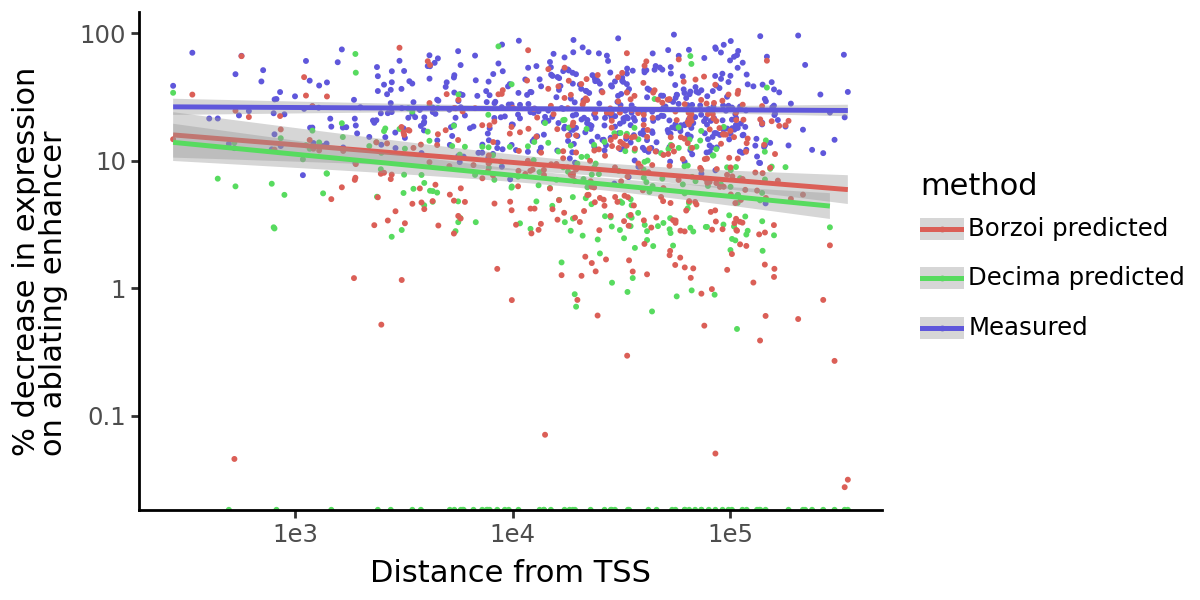

In [42]:
to_plot=gasperini[['dist_from_canonical_tss', 'delta', 'pred_delta', 'borzoi_pred_delta']]
to_plot = to_plot.rename(columns={'delta':'Measured', 'pred_delta':'Decima predicted', 'borzoi_pred_delta':'Borzoi predicted'})
    
to_plot = to_plot.melt(id_vars='dist_from_canonical_tss', var_name='method')
(
    ggplot(to_plot, aes(x='dist_from_canonical_tss', y='value', color='method'))
    +geom_point(size=.2)
    +theme_classic()
    + theme(figure_size=(6,3))
    +scale_x_log10()
    +scale_y_log10()
    + geom_smooth(method='lm')
    + xlab('Distance from TSS')
    + ylab('% decrease in expression\non ablating enhancer')
)